In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy
import warnings

import scipy
import scipy.integrate as integrate
from scipy import interpolate

import numpy as np 

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, QTable, vstack

import matplotlib.pyplot as plt

from astroquery.gaia import Gaia


In [2]:
# Directory to the stellar locus model data 

model_dir = '/Users/song/Dropbox/work/project/caterpillar/data/stellar'

# Gunn Skyker and Pickles models
gs_sum = Table.read(os.path.join(model_dir, 'gunn_stryker_sum.fits'))
pk_sum = Table.read(os.path.join(model_dir, 'pickles_sum.fits'))

print(len(gs_sum), len(pk_sum))

print(gs_sum.colnames)

149 131
['catalog', 'name', 'merian_n540_avg_vega', 'merian_n540_avg_ab', 'merian_n708_avg_vega', 'merian_n708_avg_ab', 'merian_n540_med_vega', 'merian_n540_med_ab', 'merian_n708_med_vega', 'merian_n708_med_ab', 'ps1_g_vega', 'ps1_g_ab', 'ps1_r_vega', 'ps1_r_ab', 'ps1_i_vega', 'ps1_i_ab', 'ps1_z_vega', 'ps1_z_ab', 'ps1_y_vega', 'ps1_y_ab', 'decam_g_vega', 'decam_g_ab', 'decam_r_vega', 'decam_r_ab', 'decam_i_vega', 'decam_i_ab', 'decam_z_vega', 'decam_z_ab', 'hsc_g_vega', 'hsc_g_ab', 'hsc_r_vega', 'hsc_r_ab', 'hsc_i_vega', 'hsc_i_ab', 'hsc_z_vega', 'hsc_z_ab', 'hsc_y_vega', 'hsc_y_ab', 'sdss_g_vega', 'sdss_g_ab', 'sdss_r_vega', 'sdss_r_ab', 'sdss_i_vega', 'sdss_i_ab', 'sdss_z_vega', 'sdss_z_ab']


In [3]:
# Test data 

data_dir = '~/Downloads'

#merian_cat = Table.read(os.path.join(data_dir, 'meriandr1_use_8524_S20A.fits'))
merian_cat = Table.read(os.path.join(data_dir, 'meriandr1_use_9813_S20A.fits'))

print(len(merian_cat))

print(merian_cat.colnames)

423785
['objectId_Merian', 'coord_ra_Merian', 'coord_dec_Merian', 'ebv_Merian', 'tract_Merian', 'patch_Merian', 'detect_isPrimary_Merian', 'detect_isDeblendedModelSource_Merian', 'detect_isPatchInner_Merian', 'detect_isTractInner_Merian', 'merge_peak_sky_Merian', 'deblend_skipped_Merian', 'parentObjectId_Merian', 'deblend_nChild_Merian', 'N708_gaap1p0Flux_Merian', 'N708_gaap1p0FluxErr_Merian', 'N708_gaap1p5Flux_Merian', 'N708_gaap1p5FluxErr_Merian', 'N708_gaap2p5Flux_Merian', 'N708_gaap2p5FluxErr_Merian', 'N708_blendedness_Merian', 'N708_gaapOptimalFlux_Merian', 'N708_gaapOptimalFluxErr_Merian', 'N708_cModelFlux_Merian', 'N708_cModelFluxErr_Merian', 'N708_cModelFlux_inner_Merian', 'N708_inputCount_Merian', 'N708_cModel_flag_Merian', 'N708_pixelFlags_bad_Merian', 'N708_pixelFlags_clippedCenter_Merian', 'N708_pixelFlags_cr_Merian', 'N708_pixelFlags_crCenter_Merian', 'N708_pixelFlags_edge_Merian', 'N708_pixelFlags_interpolated_Merian', 'N708_pixelFlags_interpolatedCenter_Merian', 'N708_pi

In [4]:
# Get the RA, Dec range of the Merian catalog
ra_min = np.min(merian_cat['coord_ra_Merian'])
ra_max = np.max(merian_cat['coord_ra_Merian'])
dec_min = np.min(merian_cat['coord_dec_Merian'])
dec_max = np.max(merian_cat['coord_dec_Merian'])

print("RA Range: ", ra_min, " - ", ra_max)
print("Dec Range: ", dec_min, " - ", dec_max)

# Get the coordinate of the center of the Merian catalog and the width of the catalog in the RA and Dec directions
ra_center = 0.5 * (ra_min + ra_max)
dec_center = 0.5 * (dec_min + dec_max)
center_coord = SkyCoord(ra=ra_center*u.degree, dec=dec_center*u.degree, frame='icrs')

ra_width = u.Quantity((ra_max - ra_min) + 0.01, u.deg)
dec_width = u.Quantity((dec_max - dec_min) + 0.01, u.deg)

# Query the Gaia DR3 source catalog to get the stars in the region of the Merian catalog
Gaia.ROW_LIMIT = -1
gaia_cat = Gaia.query_object_async(coordinate=center_coord, width=ra_width, height=dec_width)

print("Number of Gaia stars:", len(gaia_cat))

RA Range:  149.50414106318007  -  150.99173296015456
Dec Range:  1.487609987597303  -  2.9752051655785103
INFO: Query finished. [astroquery.utils.tap.core]
Number of Gaia stars: 8052


In [23]:
# Try to identify isolated, high S/N point sources for calibration 

# Basic quality cuts from the Merian side

# Primary detection & not skipped during deblending
merian_basic_flag = merian_cat['detect_isPrimary_Merian'] & ~merian_cat['deblend_skipped_Merian'] & \
                    (merian_cat['SciUse'] > 0) & (merian_cat['IsMask_Merian'] <1)
print(merian_basic_flag.sum() / len(merian_cat))

# Merian basic photometric cut:
# 1. Flux is possitive 
# 2. Flux error is possitive
# 3. S/N > 5
merian_basic_phot = (merian_cat['N708_gaap1p0Flux_Merian'] > 0) & (merian_cat['N708_gaap1p0FluxErr_Merian'] > 0) & \
                    (merian_cat['N540_gaap1p0Flux_Merian'] > 0) & (merian_cat['N540_gaap1p0FluxErr_Merian'] > 0) & \
                    (merian_cat['N708_gaap1p0Flux_Merian'] / merian_cat['N708_gaap1p0FluxErr_Merian'] > 5) & \
                    (merian_cat['N540_gaap1p0Flux_Merian'] / merian_cat['N540_gaap1p0FluxErr_Merian'] > 5)
print(merian_basic_phot.sum() / len(merian_cat))

# Matched with HSC and with useful photometry. Same rules, but applied to HSC bands.
hsc_basic_flag = (merian_cat['hsc_match'] > 0) & (merian_cat['IsMask_HSCS20A'] <1)
print(hsc_basic_flag.sum() / len(merian_cat))

hsc_basic_phot = (merian_cat['g_gaap1p0Flux_Merian'] > 0) & (merian_cat['g_gaap1p0FluxErr_Merian'] > 0) & \
                 (merian_cat['r_gaap1p0Flux_Merian'] > 0) & (merian_cat['r_gaap1p0FluxErr_Merian'] > 0) & \
                 (merian_cat['i_gaap1p0Flux_Merian'] > 0) & (merian_cat['i_gaap1p0FluxErr_Merian'] > 0) & \
                 (merian_cat['z_gaap1p0Flux_Merian'] > 0) & (merian_cat['z_gaap1p0FluxErr_Merian'] > 0) & \
                 (merian_cat['y_gaap1p0Flux_Merian'] > 0) & (merian_cat['y_gaap1p0FluxErr_Merian'] > 0) & \
                 (merian_cat['g_gaap1p0Flux_Merian'] / merian_cat['g_gaap1p0FluxErr_Merian'] > 5) & \
                 (merian_cat['r_gaap1p0Flux_Merian'] / merian_cat['r_gaap1p0FluxErr_Merian'] > 5) & \
                 (merian_cat['i_gaap1p0Flux_Merian'] / merian_cat['i_gaap1p0FluxErr_Merian'] > 5) & \
                 (merian_cat['z_gaap1p0Flux_Merian'] / merian_cat['z_gaap1p0FluxErr_Merian'] > 5) & \
                 (merian_cat['y_gaap1p0Flux_Merian'] / merian_cat['y_gaap1p0FluxErr_Merian'] > 5)
print(hsc_basic_phot.sum() / len(merian_cat))

# HSC blendedness cut 
# Need a threshold value for the blendedness 
blended_threshold = 0.02
# Only use r- and i-band blendedness cuts
hsc_blended_cut = (~merian_cat['g_blendedness_flag_HSCS20A']) & (~merian_cat['r_blendedness_flag_HSCS20A']) & \
                  (~merian_cat['i_blendedness_flag_HSCS20A']) & (~merian_cat['z_blendedness_flag_HSCS20A']) & \
                  (~merian_cat['y_blendedness_flag_HSCS20A']) & \
                  (merian_cat['r_blendedness_abs_HSCS20A'] < blended_threshold) & \
                  (merian_cat['i_blendedness_abs_HSCS20A'] < blended_threshold)
print(hsc_blended_cut.sum() / len(merian_cat))

# HSC extendedness cut
# Extendedness in HSC is now still 0 or 1; 0 is for point source.
hsc_extended_cut = (merian_cat['g_extendedness_value_HSCS20A'] < 0.1) & \
                   (merian_cat['r_extendedness_value_HSCS20A'] < 0.1) & \
                   (merian_cat['i_extendedness_value_HSCS20A'] < 0.1) & \
                   (merian_cat['z_extendedness_value_HSCS20A'] < 0.1) & \
                   (merian_cat['y_extendedness_value_HSCS20A'] < 0.1)
print(hsc_extended_cut.sum() / len(merian_cat))

# Combine all the cuts
good_sources = merian_basic_flag & merian_basic_phot & hsc_basic_flag & hsc_basic_phot & hsc_blended_cut & hsc_extended_cut
print(good_sources.sum() / len(merian_cat))


0.9640218507025968
0.6007527401866513
0.7853510624491192
0.4734712177165308
0.5664735656052008
0.24207086140377787
0.026924029873638757


/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_32029/2352114666.py:32: RuntimeWarning: divide by zero encountered in divide
  (merian_cat['z_gaap1p0Flux_Merian'] / merian_cat['z_gaap1p0FluxErr_Merian'] > 5) & \


11410
2523


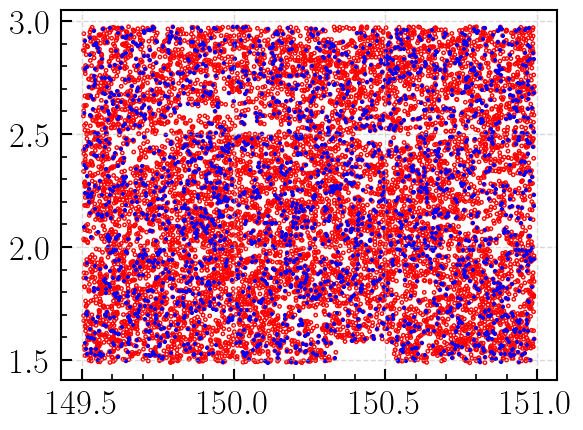

In [24]:
# Possible calibration stars 
star_catalog = merian_cat[good_sources]
print(len(star_catalog))

# Cross-match between the Gaia and Merian catalogs to identify the stars in the Gaia catalog
star_catalog['coord_ra_Merian'].unit = u.deg
star_catalog['coord_dec_Merian'].unit = u.deg

star_coords = SkyCoord(
    ra=star_catalog['coord_ra_Merian'], 
    dec=star_catalog['coord_dec_Merian']
)

gaia_coords = SkyCoord(
    ra=gaia_cat['ra'], 
    dec=gaia_cat['dec']
)

idx_gaia, sep2d_gaia, _ = gaia_coords.match_to_catalog_sky(star_coords)

# Only use the stars with small separation
idx_gaia_use = idx_gaia[sep2d_gaia.arcsec < 0.1]
print(len(idx_gaia_use))

# Define a "good" star catalog
star_catalog_use = star_catalog[idx_gaia_use]

plt.scatter(star_catalog['coord_ra_Merian'], star_catalog['coord_dec_Merian'], s=6, marker='o', facecolor='none', edgecolor='r')
plt.scatter(star_catalog['coord_ra_Merian'][idx_gaia_use], star_catalog['coord_dec_Merian'][idx_gaia_use], s=5, marker='+', color='b')

In [25]:
# Galactic extinction coefficients 
# See galactic_extinction_coefficient.ipynb for details
n708_extinction_coeff = 1.847
n540_extinction_coeff = 2.753
g_extinction_coeff = 3.234
r_extinction_coeff = 2.277
i_extinction_coeff = 1.637
z_extinction_coeff = 1.268
y_extinction_coeff = 1.084

n708_extinction_corr = star_catalog_use['ebv_Merian'] * n708_extinction_coeff
n540_extinction_corr = star_catalog_use['ebv_Merian'] * n540_extinction_coeff
g_extinction_corr = star_catalog_use['ebv_Merian'] * g_extinction_coeff
r_extinction_corr = star_catalog_use['ebv_Merian'] * r_extinction_coeff
i_extinction_corr = star_catalog_use['ebv_Merian'] * i_extinction_coeff
z_extinction_corr = star_catalog_use['ebv_Merian'] * z_extinction_coeff
y_extinction_corr = star_catalog_use['ebv_Merian'] * y_extinction_coeff

In [26]:
# Convert the fluxes used for calibration into magnitudes and perform extinction correction 
merian_zp = hsc_zp = 27.0

star_n540 = -2.5 * np.log10(star_catalog_use['N540_gaap1p0Flux_Merian']) + merian_zp - n540_extinction_corr
star_n708 = -2.5 * np.log10(star_catalog_use['N708_gaap1p0Flux_Merian']) + merian_zp - n708_extinction_corr
star_n540_err = 2.5 / np.log(10) * (star_catalog_use['N540_gaap1p0FluxErr_Merian'] / star_catalog_use['N540_gaap1p0Flux_Merian'])
star_n708_err = 2.5 / np.log(10) * (star_catalog_use['N708_gaap1p0FluxErr_Merian'] / star_catalog_use['N708_gaap1p0Flux_Merian'])

star_hsc_g = -2.5 * np.log10(star_catalog_use['g_gaap1p0Flux_Merian']) + hsc_zp - g_extinction_corr
star_hsc_r = -2.5 * np.log10(star_catalog_use['r_gaap1p0Flux_Merian']) + hsc_zp - r_extinction_corr
star_hsc_i = -2.5 * np.log10(star_catalog_use['i_gaap1p0Flux_Merian']) + hsc_zp - i_extinction_corr
star_hsc_z = -2.5 * np.log10(star_catalog_use['z_gaap1p0Flux_Merian']) + hsc_zp - z_extinction_corr
star_hsc_y = -2.5 * np.log10(star_catalog_use['y_gaap1p0Flux_Merian']) + hsc_zp - y_extinction_corr
star_hsc_g_err = 2.5 / np.log(10) * (star_catalog_use['g_gaap1p0FluxErr_Merian'] / star_catalog_use['g_gaap1p0Flux_Merian'])
star_hsc_r_err = 2.5 / np.log(10) * (star_catalog_use['r_gaap1p0FluxErr_Merian'] / star_catalog_use['r_gaap1p0Flux_Merian'])
star_hsc_i_err = 2.5 / np.log(10) * (star_catalog_use['i_gaap1p0FluxErr_Merian'] / star_catalog_use['i_gaap1p0Flux_Merian'])
star_hsc_z_err = 2.5 / np.log(10) * (star_catalog_use['z_gaap1p0FluxErr_Merian'] / star_catalog_use['z_gaap1p0Flux_Merian'])
star_hsc_y_err = 2.5 / np.log(10) * (star_catalog_use['y_gaap1p0FluxErr_Merian'] / star_catalog_use['y_gaap1p0Flux_Merian'])


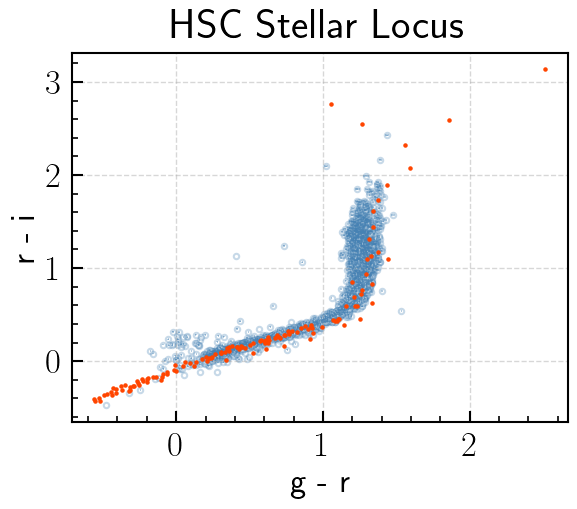

In [27]:
# Try the HSC stellar locus first to confirm our method

color_1 = star_hsc_g - star_hsc_r
color_2 = star_hsc_r - star_hsc_i

color_err_1 = np.sqrt(star_hsc_g_err**2 + star_hsc_r_err**2)
color_err_2 = np.sqrt(star_hsc_r_err**2 + star_hsc_i_err**2)

color_1_range = [-0.5, 1.7]
color_2_range = [-0.4, 2.2]
color_mask = (color_1 > color_1_range[0]) & (color_1 < color_1_range[1]) & \
             (color_2 > color_2_range[0]) & (color_2 < color_2_range[1])

plt.scatter(color_1, color_2, s=15, facecolor='w', edgecolor='steelblue', alpha=0.3, linewidth=1.5)
plt.errorbar(color_1, color_2, xerr=color_err_1, yerr=color_err_2, fmt='o', markersize=0, c='steelblue', alpha=0.4)
plt.xlabel('g - r')
plt.ylabel('r - i')
plt.title('HSC Stellar Locus')

plt.scatter(pk_sum['hsc_g_ab'] - pk_sum['hsc_r_ab'], pk_sum['hsc_r_ab'] - pk_sum['hsc_i_ab'],
            marker='o', s=5, c='orangered', zorder=9)
#plt.scatter(gs_sum['hsc_g_ab'] - gs_sum['hsc_r_ab'], gs_sum['hsc_r_ab'] - gs_sum['hsc_i_ab'])
#plt.plot(x_pre, y_pre, linestyle='--', alpha=0.8, linewidth=4, c='k')


plt.show()

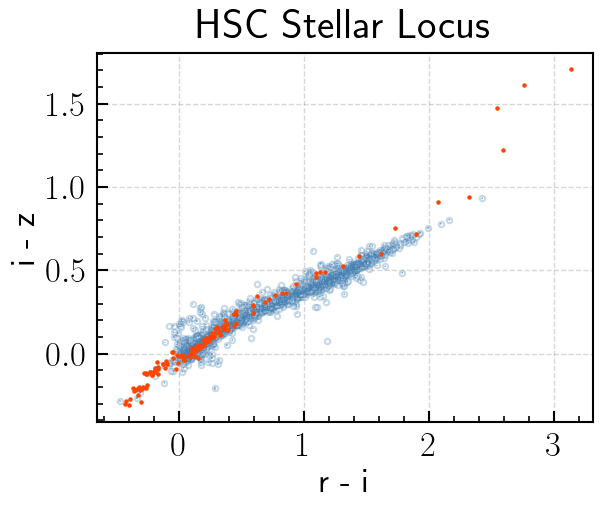

In [28]:
color_1 = star_hsc_r - star_hsc_i
color_2 = star_hsc_i - star_hsc_z

color_err_1 = np.sqrt(star_hsc_r_err**2 + star_hsc_i_err**2)
color_err_2 = np.sqrt(star_hsc_i_err**2 + star_hsc_z_err**2)

color_1_range = [-0.5, 1.7]
color_2_range = [-0.4, 2.2]
color_mask = (color_1 > color_1_range[0]) & (color_1 < color_1_range[1]) & \
             (color_2 > color_2_range[0]) & (color_2 < color_2_range[1])

plt.scatter(color_1, color_2, s=15, facecolor='w', edgecolor='steelblue', alpha=0.3, linewidth=1.5)
plt.errorbar(color_1, color_2, xerr=color_err_1, yerr=color_err_2, fmt='o', markersize=0, c='steelblue', alpha=0.4)
plt.xlabel('r - i')
plt.ylabel('i - z')
plt.title('HSC Stellar Locus')

plt.scatter(pk_sum['hsc_r_ab'] - pk_sum['hsc_i_ab'], pk_sum['hsc_i_ab'] - pk_sum['hsc_z_ab'], 
            marker='o', s=5, c='orangered', zorder=99)

plt.show()

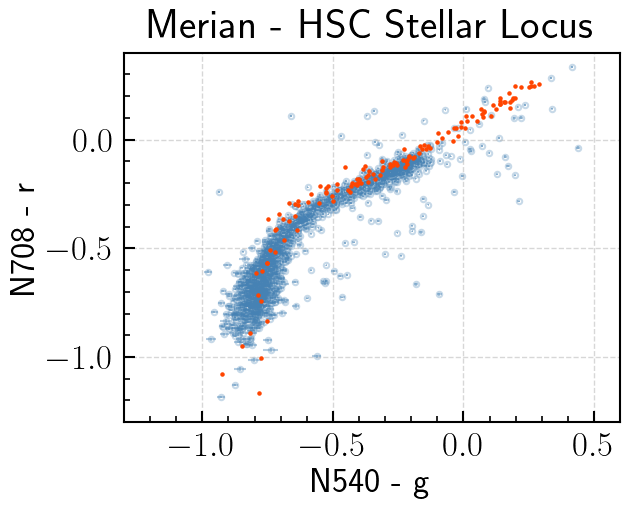

In [29]:
color_1 = star_n540 - star_hsc_g
color_2 = star_n708 - star_hsc_r

color_err_1 = np.sqrt(star_n540_err**2 + star_hsc_g_err**2)
color_err_2 = np.sqrt(star_n708_err**2 + star_hsc_r_err**2)

color_1_range = [-0.5, 1.7]
color_2_range = [-0.4, 2.2]
color_mask = (color_1 > color_1_range[0]) & (color_1 < color_1_range[1]) & \
             (color_2 > color_2_range[0]) & (color_2 < color_2_range[1])

plt.scatter(color_1, color_2, s=15, facecolor='w', edgecolor='steelblue', alpha=0.3, linewidth=1.5)
plt.errorbar(color_1, color_2, xerr=color_err_1, yerr=color_err_2, fmt='o', markersize=0, c='steelblue', alpha=0.4)

plt.xlabel('N540 - g')
plt.ylabel('N708 - r')
plt.title('Merian - HSC Stellar Locus')

plt.ylim(-1.3, 0.4)
plt.xlim(-1.3, 0.6)

plt.scatter(pk_sum['merian_n540_med_ab'] - pk_sum['hsc_g_ab'], pk_sum['merian_n708_med_ab'] - pk_sum['hsc_r_ab'],
            marker='o', s=5, c='orangered', zorder=99)
plt.show()

-0.017289369184531368 -0.021463750505329393 0.03013596024404852 -0.04850827701471876


/Users/shuang/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


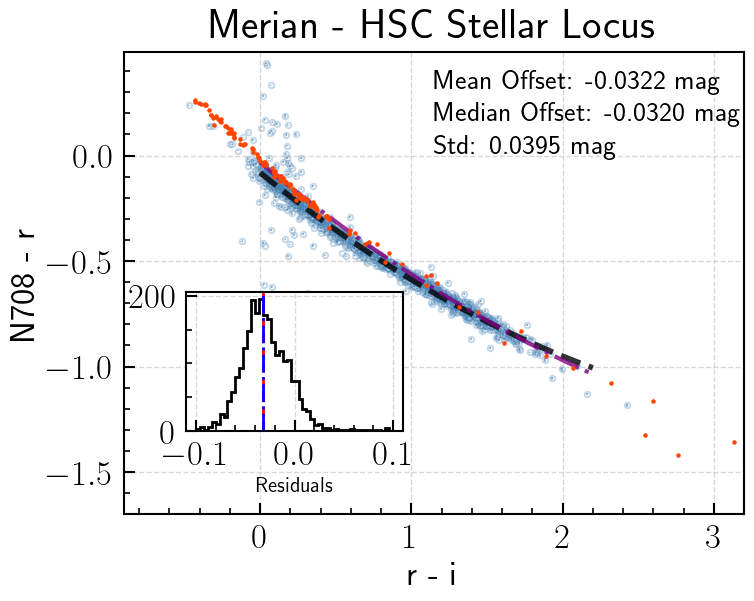

In [30]:
color_1 = star_hsc_r - star_hsc_i
color_2 = star_n708 - star_hsc_r

color_err_1 = np.sqrt(star_hsc_r_err**2 + star_hsc_i_err**2)
color_err_2 = np.sqrt(star_n708_err**2 + star_hsc_r_err**2)

color_1_range = [0.0, 2.2]
color_2_range = [-1.5, 0.0]
color_mask = (color_1 > color_1_range[0]) & (color_1 < color_1_range[1]) & \
             (color_2 > color_2_range[0]) & (color_2 < color_2_range[1])

# Order 2 polynomial fit to the stellar locus
star_poly = np.polyfit(color_1[color_mask], color_2[color_mask], 2)
x_pre = np.linspace(color_1_range[0], color_1_range[1], 100)
star_y_pre = np.poly1d(star_poly)(x_pre)

# Order 2 polynomial fit to the Pickles stellar locus model
pk_color_1 = pk_sum['hsc_r_ab'] - pk_sum['hsc_i_ab']
pk_color_2 = pk_sum['merian_n708_med_ab'] - pk_sum['hsc_r_ab']
pk_color_mask = (pk_color_1 > color_1_range[0]) & (pk_color_1 < color_1_range[1]) & \
                (pk_color_2 > color_2_range[0]) & (pk_color_2 < color_2_range[1])

pk_poly = np.polyfit(pk_color_1[pk_color_mask], pk_color_2[pk_color_mask], 2)
pk_y_pre = np.poly1d(pk_poly)(x_pre)

# Compare the two stellar loci
print(np.mean(star_y_pre - pk_y_pre), np.median(star_y_pre - pk_y_pre), np.max(star_y_pre - pk_y_pre), np.min(star_y_pre - pk_y_pre))

# Calculate the residuals
star_color_2_pk = np.poly1d(pk_poly)(color_1[color_mask])
star_color_2_res = color_2[color_mask] - star_color_2_pk

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.scatter(color_1, color_2, s=15, facecolor='w', edgecolor='steelblue', alpha=0.3, linewidth=1.5)
ax1.errorbar(color_1, color_2, xerr=color_err_1, yerr=color_err_2, fmt='o', markersize=0, c='steelblue', alpha=0.4)
ax1.set_xlabel('r - i')
ax1.set_ylabel('N708 - r')
ax1.set_title('Merian - HSC Stellar Locus')

ax1.set_xlim(-0.9, 3.2)
ax1.set_ylim(-1.7, 0.49)

ax1.plot(x_pre, star_y_pre, linestyle='--', alpha=0.8, linewidth=4, c='k')
ax1.plot(x_pre, pk_y_pre, linestyle='-.', alpha=0.8, linewidth=3, c='purple')
ax1.scatter(pk_color_1, pk_color_2, marker='o', s=5, c='orangered', zorder=99)

# Make a inset axis to show the residuals
ax2= ax1.inset_axes([0.1, 0.18, 0.35, 0.3])
_ = ax2.hist(star_color_2_res, bins=50, range=(-0.1, 0.1), histtype='step', color='k', linewidth=2)
ax2.axvline(np.mean(star_color_2_res), linestyle='--', color='r', linewidth=2)
ax2.axvline(np.median(star_color_2_res), linestyle='-.', color='b', linewidth=2)
ax2.set_xlabel('Residuals', fontsize=15)

# Show the mean and median offset and the scatter of the residual on the figure
_ = ax1.text(0.5, 0.92, f'Mean Offset: {np.mean(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)
_ = ax1.text(0.5, 0.85, f'Median Offset: {np.median(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)
_ = ax1.text(0.5, 0.78, f'Std: {np.nanstd(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)

-0.028959165846401288 -0.02368867077459838 -0.0191159042294341 -0.05718156580523198


/Users/shuang/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


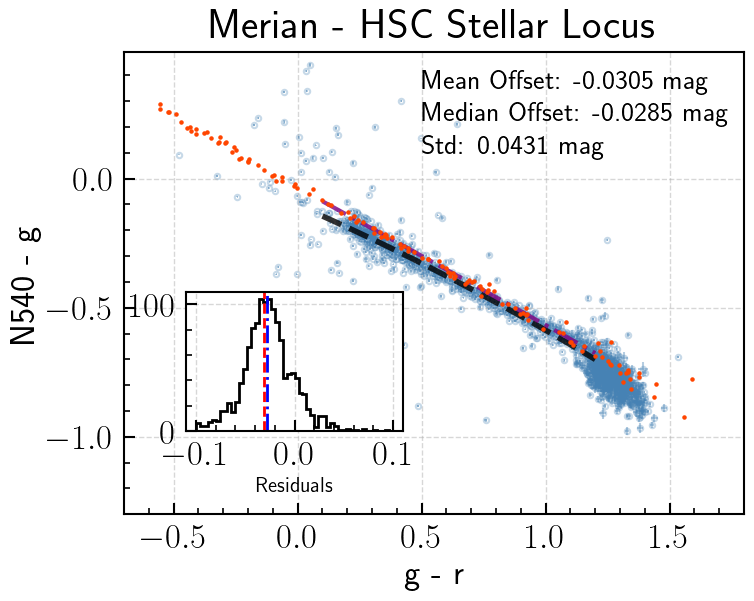

In [31]:
color_1 = star_hsc_g - star_hsc_r
color_2 = star_n540 - star_hsc_g

color_err_1 = np.sqrt(star_hsc_g_err**2 + star_hsc_r_err**2)
color_err_2 = np.sqrt(star_n540_err**2 + star_hsc_g_err**2)

color_1_range = [0.1, 1.2]
color_2_range = [-0.9, -0.1]
color_mask = (color_1 > color_1_range[0]) & (color_1 < color_1_range[1]) & \
             (color_2 > color_2_range[0]) & (color_2 < color_2_range[1])

# Order 2 polynomial fit to the stellar locus
star_poly = np.polyfit(color_1[color_mask], color_2[color_mask], 2)
x_pre = np.linspace(color_1_range[0], color_1_range[1], 100)
star_y_pre = np.poly1d(star_poly)(x_pre)

# Order 2 polynomial fit to the Pickles stellar locus model
pk_color_1 = pk_sum['hsc_g_ab'] - pk_sum['hsc_r_ab']
pk_color_2 = pk_sum['merian_n540_med_ab'] - pk_sum['hsc_g_ab']
pk_color_mask = (pk_color_1 > color_1_range[0]) & (pk_color_1 < color_1_range[1]) & \
                (pk_color_2 > color_2_range[0]) & (pk_color_2 < color_2_range[1])

pk_poly = np.polyfit(pk_color_1[pk_color_mask], pk_color_2[pk_color_mask], 2)
pk_y_pre = np.poly1d(pk_poly)(x_pre)

# Compare the two stellar loci
print(np.mean(star_y_pre - pk_y_pre), np.median(star_y_pre - pk_y_pre), np.max(star_y_pre - pk_y_pre), np.min(star_y_pre - pk_y_pre))

# Calculate the residuals
star_color_2_pk = np.poly1d(pk_poly)(color_1[color_mask])
star_color_2_res = color_2[color_mask] - star_color_2_pk

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.scatter(color_1, color_2, s=15, facecolor='w', edgecolor='steelblue', alpha=0.3, linewidth=1.5)
ax1.errorbar(color_1, color_2, xerr=color_err_1, yerr=color_err_2, fmt='o', markersize=0, c='steelblue', alpha=0.4)
ax1.set_xlabel('g - r')
ax1.set_ylabel('N540 - g')
ax1.set_title('Merian - HSC Stellar Locus')

ax1.set_xlim(-0.7, 1.8)
ax1.set_ylim(-1.3, 0.49)

ax1.plot(x_pre, star_y_pre, linestyle='--', alpha=0.8, linewidth=4, c='k')
ax1.plot(x_pre, pk_y_pre, linestyle='-.', alpha=0.8, linewidth=3, c='purple')
ax1.scatter(pk_color_1, pk_color_2, marker='o', s=5, c='orangered', zorder=99)

# Make a inset axis to show the residuals
ax2= ax1.inset_axes([0.1, 0.18, 0.35, 0.3])
_ = ax2.hist(star_color_2_res, bins=50, range=(-0.1, 0.1), histtype='step', color='k', linewidth=2)
ax2.axvline(np.mean(star_color_2_res), linestyle='--', color='r', linewidth=2)
ax2.axvline(np.median(star_color_2_res), linestyle='-.', color='b', linewidth=2)
ax2.set_xlabel('Residuals', fontsize=15)

# Show the mean and median offset and the scatter of the residual on the figure
_ = ax1.text(0.48, 0.92, f'Mean Offset: {np.mean(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)
_ = ax1.text(0.48, 0.85, f'Median Offset: {np.median(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)
_ = ax1.text(0.48, 0.78, f'Std: {np.nanstd(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)

0.019006533272517917 0.021984778414198464 0.030674508269663003 -0.006836079966950015


/Users/shuang/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


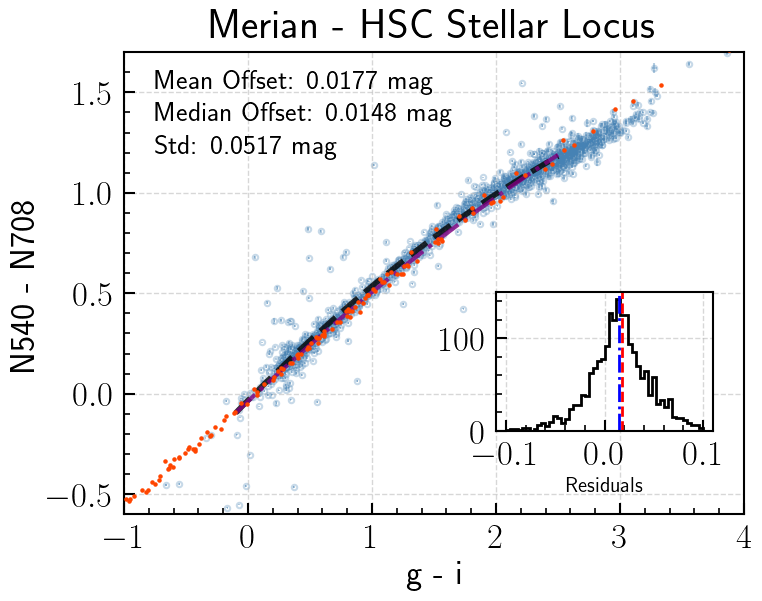

In [32]:
color_1 = star_hsc_g - star_hsc_i
color_2 = star_n540 - star_n708

color_err_1 = np.sqrt(star_hsc_g_err**2 + star_hsc_i_err**2)
color_err_2 = np.sqrt(star_n540_err**2 + star_n708_err**2)

color_1_range = [-0.1, 2.5]
color_2_range = [0.0, 1.2]
color_mask = (color_1 > color_1_range[0]) & (color_1 < color_1_range[1]) & \
             (color_2 > color_2_range[0]) & (color_2 < color_2_range[1])

# Order 2 polynomial fit to the stellar locus
star_poly = np.polyfit(color_1[color_mask], color_2[color_mask], 2)
x_pre = np.linspace(color_1_range[0], color_1_range[1], 100)
star_y_pre = np.poly1d(star_poly)(x_pre)

# Order 2 polynomial fit to the Pickles stellar locus model
pk_color_1 = pk_sum['hsc_g_ab'] - pk_sum['hsc_i_ab']
pk_color_2 = pk_sum['merian_n540_med_ab'] - pk_sum['merian_n708_med_ab']
pk_color_mask = (pk_color_1 > color_1_range[0]) & (pk_color_1 < color_1_range[1]) & \
                (pk_color_2 > color_2_range[0]) & (pk_color_2 < color_2_range[1])

pk_poly = np.polyfit(pk_color_1[pk_color_mask], pk_color_2[pk_color_mask], 2)
pk_y_pre = np.poly1d(pk_poly)(x_pre)

# Compare the two stellar loci
print(np.mean(star_y_pre - pk_y_pre), np.median(star_y_pre - pk_y_pre), np.max(star_y_pre - pk_y_pre), np.min(star_y_pre - pk_y_pre))

# Calculate the residuals
star_color_2_pk = np.poly1d(pk_poly)(color_1[color_mask])
star_color_2_res = color_2[color_mask] - star_color_2_pk

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.scatter(color_1, color_2, s=15, facecolor='w', edgecolor='steelblue', alpha=0.3, linewidth=1.5)
ax1.errorbar(color_1, color_2, xerr=color_err_1, yerr=color_err_2, fmt='o', markersize=0, c='steelblue', alpha=0.4)
ax1.set_xlabel('g - i')
ax1.set_ylabel('N540 - N708')
ax1.set_title('Merian - HSC Stellar Locus')

ax1.set_ylim(-0.6, 1.7)
ax1.set_xlim(-1.0, 4.0)

ax1.plot(x_pre, star_y_pre, linestyle='--', alpha=0.8, linewidth=4, c='k')
ax1.plot(x_pre, pk_y_pre, linestyle='-.', alpha=0.8, linewidth=3, c='purple')
ax1.scatter(pk_color_1, pk_color_2, marker='o', s=5, c='orangered', zorder=99)

# Make a inset axis to show the residuals
ax2= ax1.inset_axes([0.6, 0.18, 0.35, 0.3])
_ = ax2.hist(star_color_2_res, bins=50, range=(-0.1, 0.1), histtype='step', color='k', linewidth=2)
ax2.axvline(np.mean(star_color_2_res), linestyle='--', color='r', linewidth=2)
ax2.axvline(np.median(star_color_2_res), linestyle='-.', color='b', linewidth=2)
ax2.set_xlabel('Residuals', fontsize=15)

# Show the mean and median offset and the scatter of the residual on the figure
_ = ax1.text(0.05, 0.92, f'Mean Offset: {np.mean(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)
_ = ax1.text(0.05, 0.85, f'Median Offset: {np.median(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)
_ = ax1.text(0.05, 0.78, f'Std: {np.nanstd(star_color_2_res):.4f} mag', transform=ax1.transAxes, fontsize=20)